# Minimal Implementation for Dynamics of Specialization

In this example, we will implement a 2-module modular architecture from https://arxiv.org/abs/2106.02626

We will examine 3 levels of structural modularity $Q$, by changing the amount of interconnection $p$ present between modules

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from functools import partial
import copy
from tqdm.notebook import tqdm
import matplotlib

In [2]:
%load_ext autoreload
%autoreload 2


## Data

### Generate

We generate double-MNIST data, suited for a 2-module modular architecture

In [3]:
from dynspec.datasets import get_datasets
from dynspec.data_process import process_data

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
n_modules = 2
n_classes_per_digit = 10
n_classes = n_classes_per_digit * n_modules
nb_steps = 5

data_config = {
    # ------ Change if needed------
    "batch_size": 256,
    "input_size": 28,
    "use_cuda": use_cuda,
    "data_type": "double_digits",
    "n_digits": n_modules,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "nb_steps": nb_steps,
    # cov ratio : controls the probabilty of seeing D1 == D2, default = 1 (chance probability)
    "cov_ratio": 1,
    # noise ratio : controls the ammount of noise added to the input , default = 0.4
    "noise_ratio": 0.4,
    # random start : add stochasticity by having input start at random times from pure noise, default = False
    "random_start": False,
    # --------------------------
}


In [6]:
all_data = get_datasets("../data/", data_config)
datasets, loaders = all_data[data_config["data_type"]]
len(datasets[0])

60000

### Plot

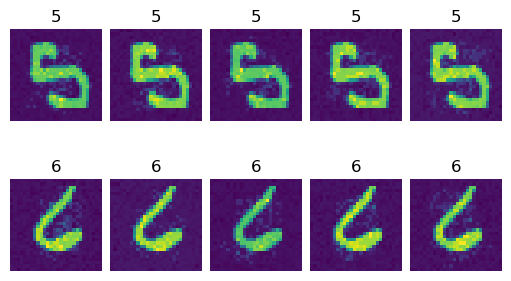

In [7]:
data, target = next(iter(loaders[0]))

temporal_data, _ = process_data(data, data_config)
temporal_data = torch.stack(
    temporal_data.split(temporal_data.shape[-1] // n_modules, -1), 1
)

fig, axs = plt.subplots(
    n_modules, temporal_data.shape[0], constrained_layout=True, figsize=(5, 3)
)
for t_data, t_axs in zip(temporal_data, axs.T):
    for d, ax, t in zip(t_data, t_axs, target[0].cpu().numpy()):
        ax.imshow(d[0].cpu().numpy().reshape(28, 28))
        ax.axis("off")
        ax.set_title(t)


## Init Models

Initialization of models with varying ammount of structural modularity

In [8]:
from dynspec.models import Community, init_model
from dynspec.data_process import flatten_list
from torch.nn import RNN, GRU, RNNCell, GRUCell
from dynspec.plotting import plot_model_masks
import pandas as pd
from dynspec.training import train_community, get_acc, get_loss
from dynspec.experiment import Experiment

In [9]:
# feel free to try other tasks, such as 'sum'
task = "parity-digits-both"

modules_config = {
    "n_modules": 2,
    "hidden_size": None,  # will be changed later
    "n_layers": 1,
    "dropout": 0.0,
    "cell_type": str(RNN),
}
connections_config = {"sparsity": None}  # Will be changed later
input_config = {"input_size": data_config["input_size"] ** 2, "common_input": False}
optim_config = {"lr": 1e-3, "weight_decay": 1e-5}
readout_config = {"common_readout": False}
decision = ["last", "max"]
training_config = {"n_epochs": 30, "task": task, "stop_acc": 0.95}

default_config = {
    "modules": modules_config,
    "connections": connections_config,
    "input": input_config,
    "readout": readout_config,
    "data": data_config,
    "decision": decision,
    "training": training_config,
    "optim": optim_config,
}

In [10]:
# We look at networks of 1/3 sizes and 5 sparsity levels
n_hiddens = [25]
# n_hiddens = [10, 25, 50][1:2]
# Negative values for the sparsity field directly specify number of connections (irrelevant of the hidden size) : eg -1 means exactly 1 connection
sparsities = [-1, 1e-2, 1e-1, 0.5, 1.0]
varying_params = {"hidden_size": n_hiddens, "sparsity": sparsities}


In [11]:
# Save yourself some training time by pre-loading the results, or check out training by yourself. On a gpu, it should take about 5 minutes per model (30 epochs)
experiment = Experiment(
    default_config, varying_params, load_save=True, n_tests=1, device=device
)

Results loaded


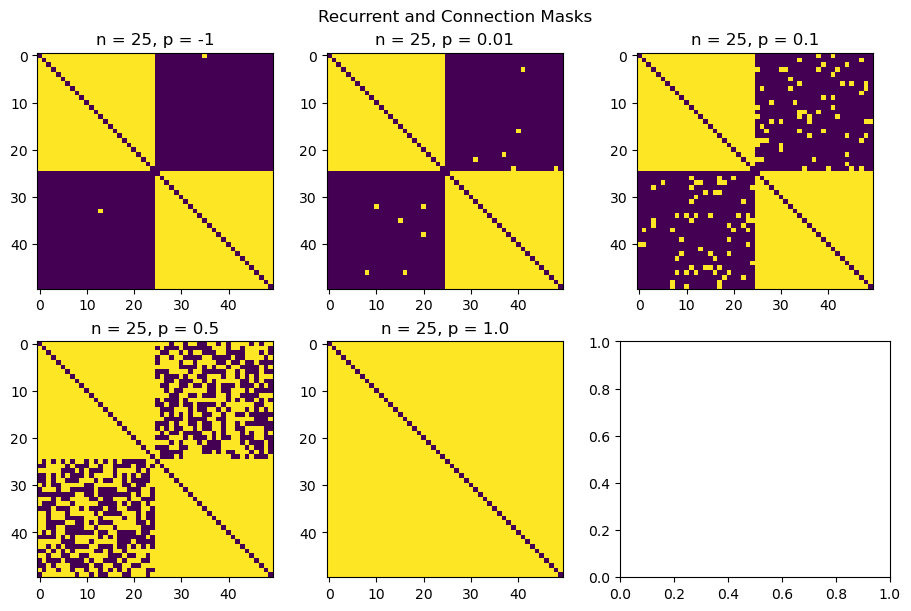

In [12]:
# plot the reccurent connections of the models, this changes depending on the sparsity of intereconnections
plot_model_masks(experiment, plot_input=False)


## Training

In [15]:
if not experiment.loaded:
    experiment.run(loaders, save=True)

### Results

In [16]:
from dynspec.plotting import plot_accs


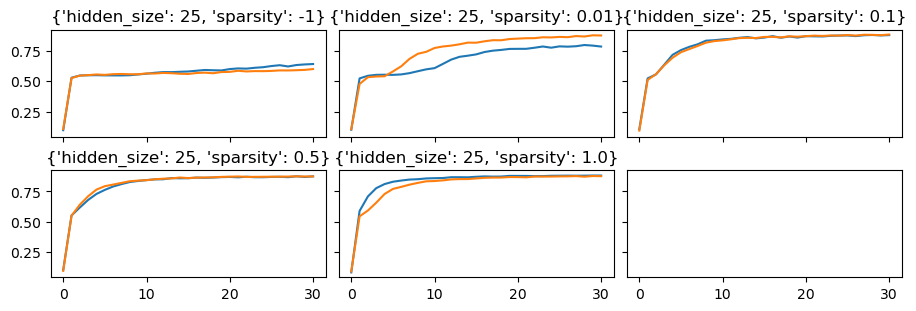

In [17]:
plot_accs(experiment.results)


In [ ]:
raise StopIteration


## Metrics

In [24]:
from dynspec.plotting import set_style, filter_data
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from dynspec.metrics import global_diff_metric

### Retraining

In [34]:
from dynspec.plotting import plot_retraining_results

In [45]:
experiment.compute_retraining_metric(loaders, save=True)

  0%|          | 0/5 [00:00<?, ?it/s]

Results saved


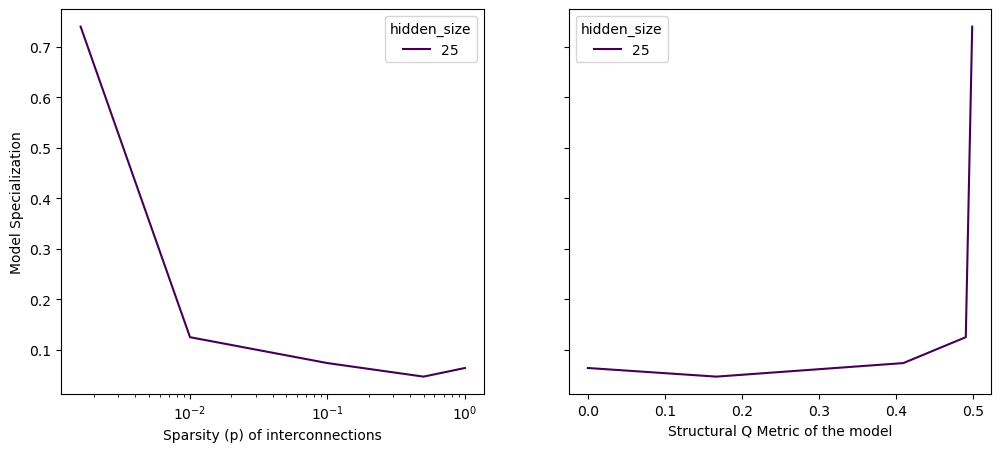

In [46]:
plot_retraining_results(experiment)

In [47]:
experiment.retrained_models

(Community(
   (core): ParametrizedRNN(
     1568, 50, bias=False
     (parametrizations): ModuleDict(
       (weight_ih_l0): ParametrizationList(
         (0): Masked_weight()
       )
       (weight_hh_l0): ParametrizationList(
         (0): Masked_weight()
         (1): Scaled_mask_weight()
       )
     )
   )
   (readout): Readout(
     (layers): ModuleList(
       (0-1): 2 x ModuleList(
         (0-1): 2 x Sequential(
           (0): ParametrizedLinear(
             in_features=50, out_features=30, bias=True
             (parametrizations): ModuleDict(
               (weight): ParametrizationList(
                 (0): Masked_weight()
               )
             )
           )
           (1): ReLU()
           (2): Linear(in_features=30, out_features=10, bias=True)
         )
       )
       (2): ModuleList(
         (0-1): 2 x Sequential(
           (0): Linear(in_features=50, out_features=30, bias=True)
           (1): ReLU()
           (2): Linear(in_features=30, out_feature

### Random Timings

In [41]:
from tqdm.notebook import tqdm

In [42]:
all_outputs = []
all_start_times = []
all_targets = []

random_config = default_config.copy()
random_config["data"]["random_start"] = True


def reccursive_stack(input):
    try:
        return torch.stack(input)
    except TypeError:
        return torch.stack([reccursive_stack(i) for i in input])


for n, s in enumerate(tqdm(experiment.varying_params['sparsity'])):
    all_outputs.append([])
    all_start_times.append([])
    all_targets.append([])

    for net, config in zip(
        experiment.retrained_models, experiment.all_configs
    ):
        all_outputs[-1].append([])
        all_start_times[-1].append([])
        all_targets[-1].append([])

        for data, target in loaders[1]:
            data, start_times = process_data(data, random_config["data"])
            data, target = data.to(device), target.to(device)
            outputs, _ = net(data)
            outputs = reccursive_stack(outputs).transpose(0, 2).squeeze()
            all_outputs[-1][-1].append(outputs)  # steps x modules x target
            all_start_times[-1][-1].append(start_times)
            all_targets[-1][-1].append(target)

        all_outputs[-1][-1] = torch.cat(all_outputs[-1][-1], -2)
        all_start_times[-1][-1] = torch.cat(all_start_times[-1][-1], -2)
        all_targets[-1][-1] = torch.cat(all_targets[-1][-1], -2)


NameError: name 'config' is not defined

In [ ]:
all_outputs, all_start_times, all_targets = [
    {n_s: reccursive_stack(r).squeeze() for n_s, r in zip(n_conns, all_r)}
    for all_r in [all_outputs, all_start_times, all_targets]
]

In [ ]:
if n_tests == 1:
    all_outputs, all_targets, all_start_times = [
        {n: t.unsqueeze(0) for n, t in d.items()}
        for d in [all_outputs, all_targets, all_start_times]
    ]

In [ ]:
all_accs = {
    n_s: np.stack(
        [
            get_acc(
                o,
                [
                    [[t for t in target.T] for _ in range(n_modules + 1)]
                    for _ in range(nb_steps)
                ],
            )[1]
            for o, target in zip(all_outs, all_ts)
        ]
    )
    for (n_s, all_outs), all_ts in zip(all_outputs.items(), all_targets.values())
}

all_accs[n_conns[0]].shape

(1, 5, 3, 2, 7680)

In [ ]:
all_u_masks = {
    n_s: np.array(
        [[(all_s == u).all(-1) for u in all_s.unique(dim=0)] for all_s in all_start]
    )
    for n_s, all_start in all_start_times.items()
}
all_u_masks[n_conns[0]].shape

(1, 9, 7680)

In [ ]:
plot_data = {
    "t0": [],
    "t1": [],
    "t0_t1": [],
    "step": [],
    "local_metric": [],
    "ag": [],
    "n_conns": [],
}

for n_s in all_accs.keys():
    # for u_masks, accs, start_times in zip(
    #     all_u_masks[n_s], all_accs[n_s], all_start_times[n_s]
    # ):
    for test in range(n_tests):
        u_masks, accs, start_times = (
            all_u_masks[n_s],
            all_accs[n_s],
            all_start_times[n_s],
        )
        for mask, pair in zip(u_masks[test], start_times[test].unique(dim=0)):
            for step in range(nb_steps):
                for ag in range(n_modules + 1):
                    # plot_data['global_metric'].append(diff_metric(all_accs[step, -1, :, mask].mean(0)))
                    plot_data["local_metric"].append(
                        diff_metric(accs[test, step, ag, :, mask].mean(0))
                    )
                    # plot_data['local_metric_1'].append(diff_metric(all_accs[step, 1, :, mask].mean(0)))
                    plot_data["t0"].append(pair[0].item())
                    plot_data["t1"].append(pair[1].item())
                    plot_data["t0_t1"].append(tuple(pair.cpu().data.numpy()))
                    plot_data["step"].append(step)
                    plot_data["ag"].append(ag)
                    plot_data["n_conns"].append(n_s)
                    # plot_data['x'].append([-1, 1][ag] * (accs.shape[0] - step))
                    # plot_data['x'].append(step)

            # plot_data['local_metric'].append(diff_metric(accs[step, -1, :, mask].mean(0)))
            # plot_data['t0'].append(pair[0].item())
            # plot_data['t1'].append(pair[1].item())
            # plot_data['t0_t1'].append(tuple(pair.cpu().data.numpy()))
            # plot_data['step'].append(nb_steps)
            # plot_data['ag'].append(-1)

plot_data = pd.DataFrame.from_dict(plot_data)

In [ ]:
last_ts_data = [
    filter_data(plot_data, {"ag": 2, "step": nb_steps - 1})[0] for _ in range(n_modules)
]
for ag, data in enumerate(last_ts_data):
    data.loc[:, "ag"] = ag
    data.loc[:, "step"] = nb_steps

last_ts_data = pd.concat(last_ts_data)
plot_data = filter_data(pd.concat([plot_data, last_ts_data]), {"!ag": 2})[0]

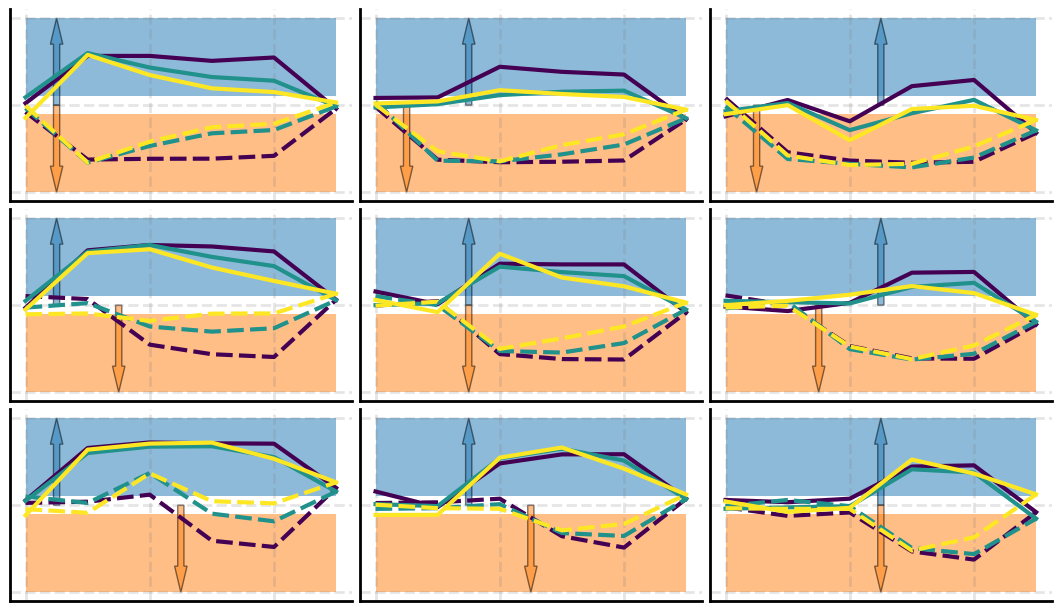

In [ ]:
fig, axs = plt.subplots(
    3, 3, figsize=(3 * 3.5, 3 * 2), constrained_layout=True, sharex=True, sharey=True
)
set_style()

for u, ax in zip(plot_data["t0_t1"].unique(), axs.T.flatten()):
    t0, t1 = u
    sns.lineplot(
        filter_data(
            plot_data, {"t0_t1": u, "n_conns": [n_conns[i] for i in [0, 1, 2]]}
        )[0],
        y="local_metric",
        x="step",
        ax=ax,
        style="ag",
        hue="n_conns",
        palette="viridis",
        hue_norm=LogNorm(),
    )
    # ax.vlines(x = [t0 - 0.5 ], ymin = -1, ymax = 1, color = 'blue', alpha = .2)
    # ax.vlines(x = [t1 - 0.5 ], ymin = -1, ymax = 1, color = 'red', alpha = .2)
    c1 = ax.fill_betweenx([0.1, 1], 0, nb_steps, alpha=0.5, label="M0")
    c2 = ax.fill_betweenx([-0.1, -1], 0, nb_steps, alpha=0.5, label="M1")

    ax.arrow(
        t0 - 0.5,
        0,
        0,
        1,
        alpha=0.5,
        width=0.1,
        head_width=0.2,
        facecolor=c1.get_facecolor()[0],
        edgecolor="black",
        length_includes_head=True,
        linewidth=1,
    )
    ax.arrow(
        t1 - 0.5,
        0,
        0,
        -1,
        alpha=0.5,
        width=0.1,
        head_width=0.2,
        facecolor=c2.get_facecolor()[0],
        edgecolor="black",
        length_includes_head=True,
        linewidth=1,
    )
    ax.legend()
    # ax.set_title(u)

    if t1 == 3:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    if t0 == 1:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("")

    ax.legend().remove()

    ax.grid(True, alpha=0.2, linestyle="dashed", linewidth=2, color="grey")
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)

# fig.savefig(f"../results/imgs/random_noisy_timings_new_3.svg")

In [ ]:
# plot_data.to_csv(f"../results/random_noisy_timings_data")